# Importing Packages

In [46]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(['science', 'notebook', 'grid'])
import scipy as sp
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [47]:
def plot_actual_and_predicted(x_actual_data,x_pred_data):
	
    #checking the plots
	dt = 0.05
	timeaxis = np.arange(0, (x_actual_data.shape[0])*dt, dt)
	# Plot data on each subplot
	plt.figure(figsize=(15,3))
	plt.plot(timeaxis, x_actual_data, label="x1",color="orange",lw=1.1)
	plt.plot(timeaxis, x_pred_data, label="x1_pred",ls="--" , color='blue', lw=1.1)  
	plt.ylabel("x")
	plt.xlabel("n")
	plt.ylim(-0.1,1)
	plt.title("Comparison of the Predicted and Actual Data")
	plt.legend(loc='upper right')
	plt.show()

## 1. Bifurcation for the system 

$$\dot{x} = -x + \frac{k_1}{2}(x - x^3) + \frac{k_2}{2}(x^3 - x^5) $$

Here $K_2$ is kept as 0

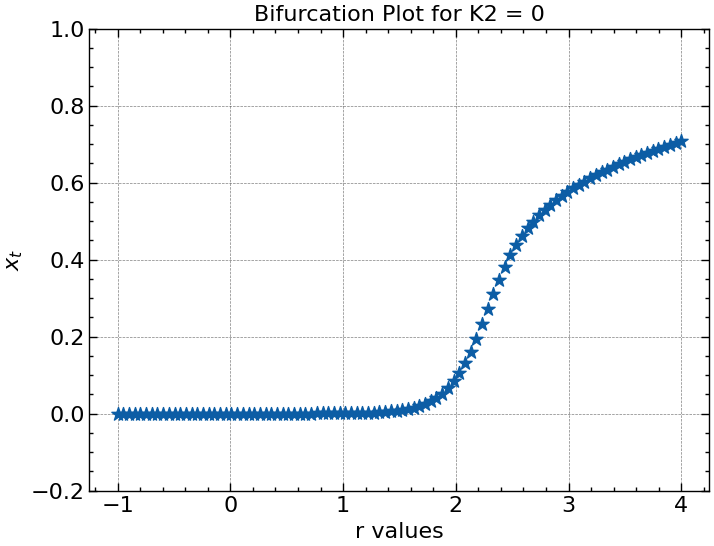

In [48]:
def dxdt(t,x,k_1,k_2):
  return -x + (k_1/2)*(x - x**3) + (k_2/2)*(x**3-x**5)

k_1_values = np.linspace(-1,4,100)
k_2 = 0
x0 = 0.1

x_values = []
t = np.linspace(0,10,1000)

for k_1 in k_1_values: 
  solution = odeint(dxdt, y0=x0, t=t,args=(k_1,k_2), tfirst=True)
  x_values.append(solution[990])

plt.scatter(k_1_values,x_values,marker="*")
plt.xlabel("r values")
plt.ylabel(r"$x_t$")
plt.title("Bifurcation Plot for K2 = 0")
plt.ylim(-0.2,1)
plt.grid(True)

# Obtaining data

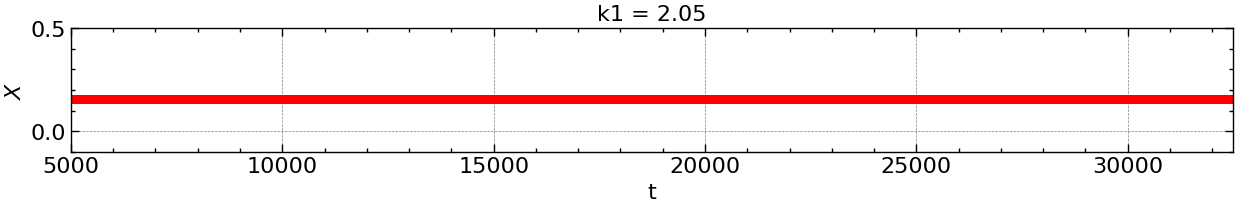

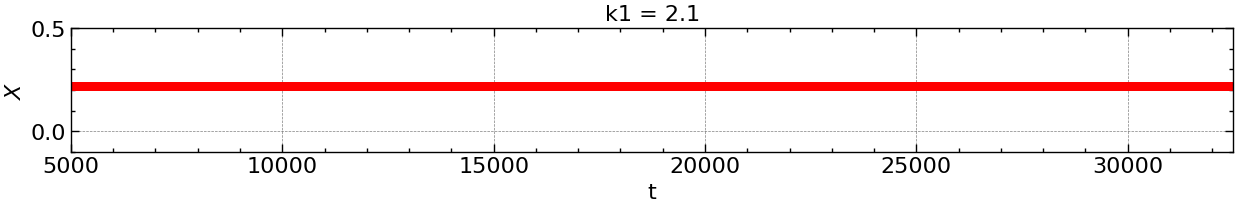

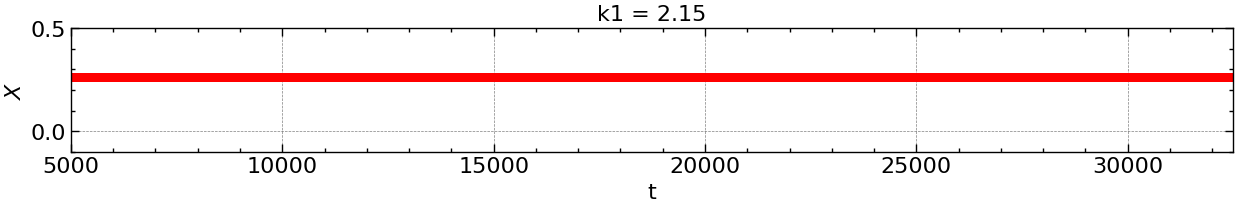

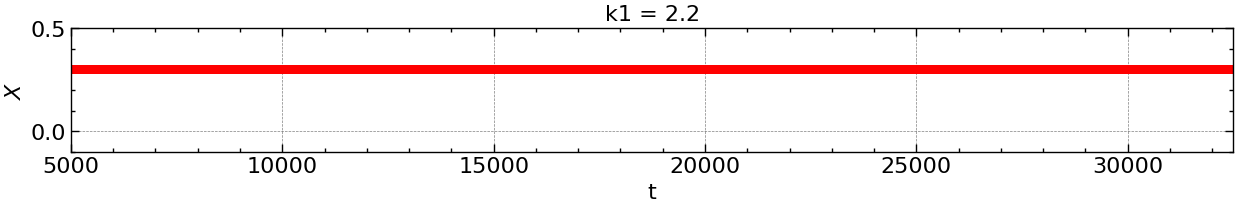

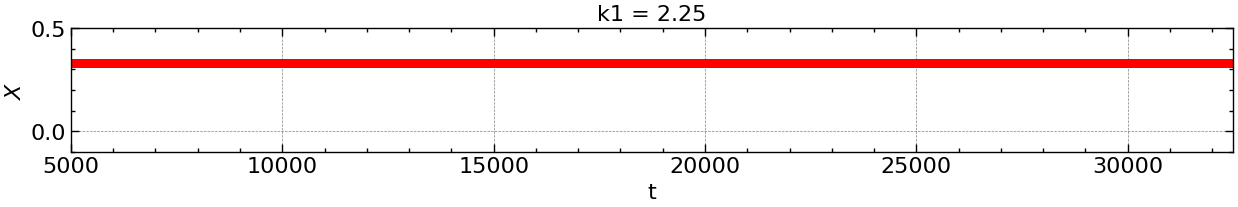

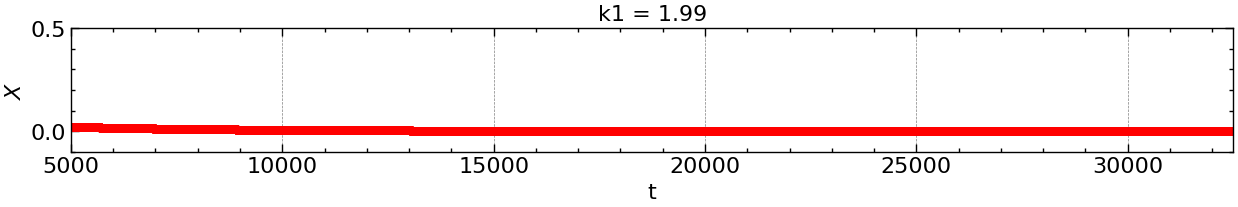

(1, 216000)


In [49]:
def dxdt(t,x,k_1,k_2):
  dxdt = -x + (k_1*x*(1 - x**2))/2 + (k_2*x*(x**2-x**4))/2
  return dxdt

k_1_values = [2.05,2.1,2.15,2.2,2.25,1.99]
k2 = 0
data_x_list = []
dt = 0.05
timesteps = 36000
t = np.linspace(0, timesteps * dt, timesteps)

for k1 in k_1_values:
    x0 = 0.4
    x_data = odeint(dxdt, y0=x0, t=t,args=(k1,k2), tfirst=True)
    data_x_list.append(x_data)
    plt.figure(figsize=(15, 1.6))
    plt.plot(x_data, marker=".", color = "red")
    plt.title("k1 = {}".format(k1))
    plt.xlabel("t")
    plt.ylabel(r"$X$")

    plt.ylim(-0.1,0.5)
    plt.xlim(5000,32500)
    plt.grid(True)
    plt.show()

stacked_total = np.transpose(np.vstack(data_x_list))                                # See rough notebook
       # shape is 1 x 36000*4
print(stacked_total.shape)

In [50]:
from PaResPy import ReservoirComputer as PARC

training_data,valid_data,train_without_transient = PARC.train_test_split(stacked_total)

 The training data shape : (80000, 1)
 The testing data shape : (16000, 1)


In [51]:
dim_system = 1
alpha = 1
dim_reservoir, rho, sigma, k_b =  [200,0.35, 0.3687693621523779, 0.19]
eps_train = [2.05,2.1,2.15,2.2,2.25]
model = PARC(dim_system, dim_reservoir, rho, sigma, k_b, alpha) 
model.train(training_data, train_without_transient, eps_train)

# Prediction of system for different $k_1$ values

The NRMSE value of mu value 1.9 : 27.800580048314625


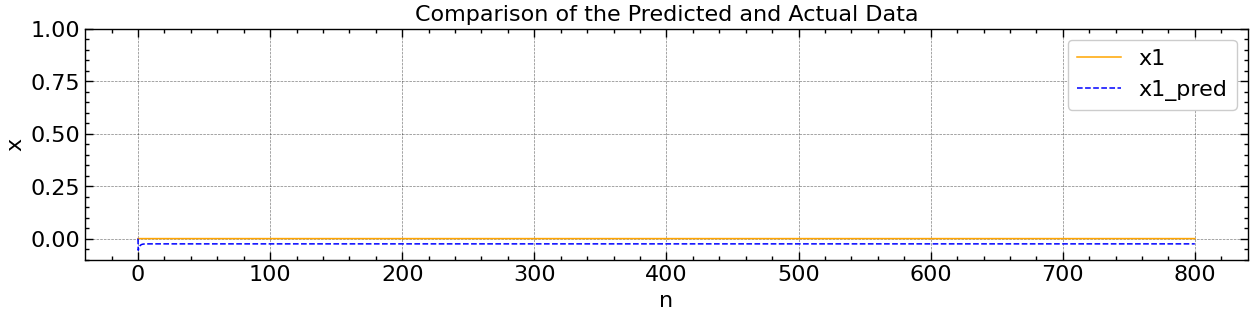

The NRMSE value of mu value 1.95 : 2.490129314965005


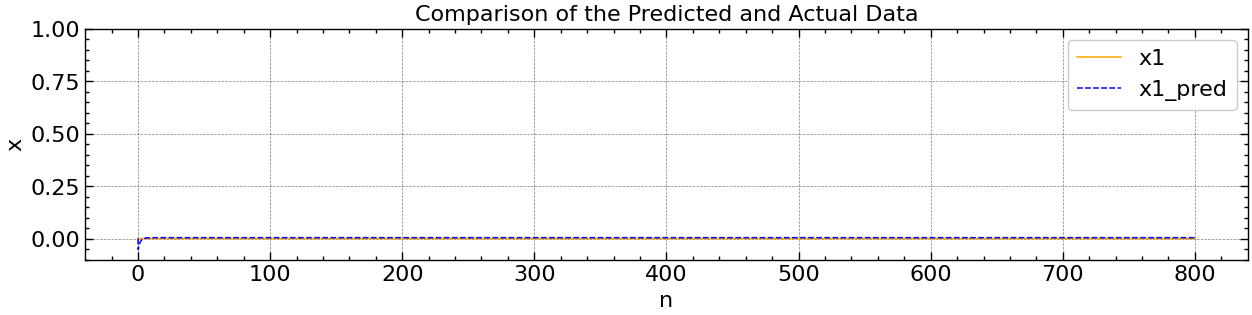

The NRMSE value of mu value 2.08 : 1.02565885941492


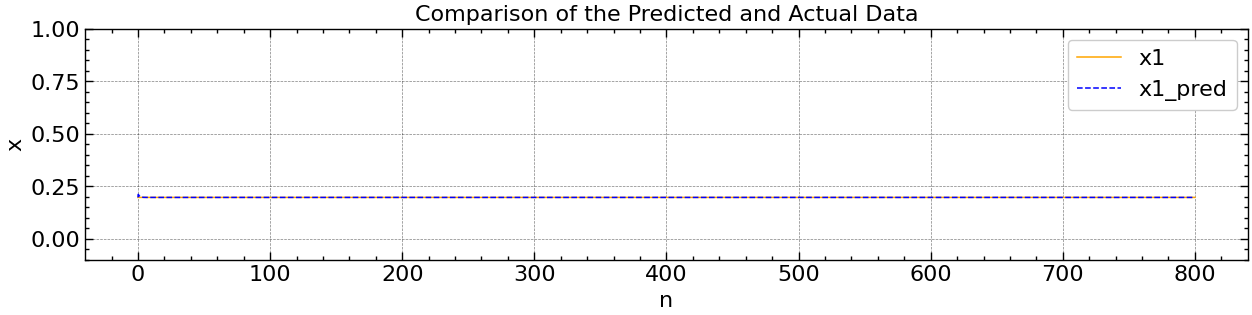

The NRMSE value of mu value 2.1 : 1.0000485531722985


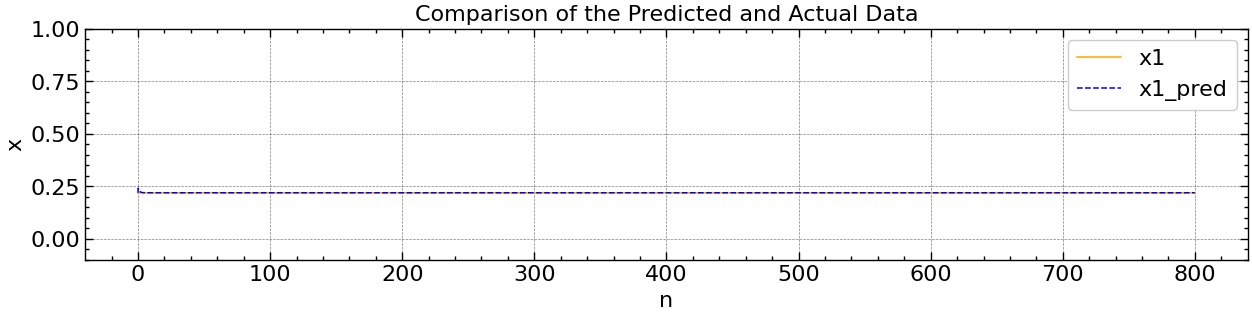

The NRMSE value of mu value 2.15 : 1.0036007112380976


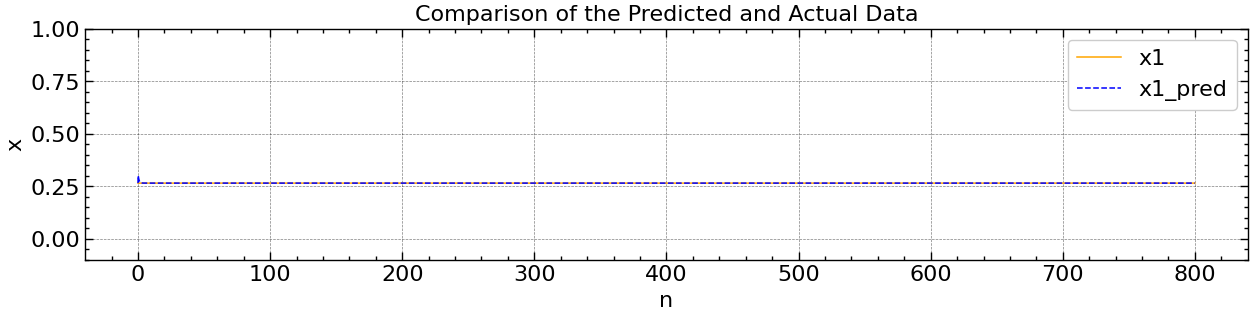

In [52]:
k1_test_val = [1.9,1.95,2.08,2.1,2.15]

for k1 in k1_test_val:
	k_data = odeint(dxdt, y0=x0, t=t,args=(k1,k2), tfirst=True)
	valid_data = k_data[-16000:]
	predicted_data, Res_test_total = model.predict(k1,len(valid_data), valid_data, train_without_transient)
	total_var = np.var(predicted_data)
	NRMSE = np.sqrt(np.mean((valid_data[:] - predicted_data[:]) ** 2) / total_var)
	print("The NRMSE value of mu value {} :".format(k1), NRMSE)

	plot_actual_and_predicted(valid_data,predicted_data)


# Map Analysis

In the map nalysis of this there is no point where a stable point becomes unstable

In [53]:
A, W_in, W_out, W_b = model.get_weights()
eb = 0
#print(W_out)
# epsilon_train = 3.63

Lambda = A + np.matmul(W_in, W_out)
Omega = k_b * W_b


In [54]:
import eigen_analysis as eg
epsilon_list=np.array([1.95,2.04,2.35])
analysis_model = eg.eigenvalues(eb,alpha,Lambda,Omega,dim_reservoir)
eig_array = analysis_model.eigen_values(epsilon_list,int_guess=-0.4)

[ 0.51143984  0.27071751  0.66424119 -0.62777679  0.34861651 -0.11712429
 -0.42165269 -0.29483279  0.17761763 -0.66662519]
[ 0.56888091  0.3233172   0.62691809 -0.57643801  0.29706343 -0.11650337
 -0.43649312 -0.37790119  0.35962243 -0.64793358]
[ 0.56971126  0.30352077  0.76091163 -0.72072685  0.44123239 -0.13993763
 -0.49408271 -0.33424913  0.13896701 -0.75720346]


c:\Users\User\Desktop\Coding\Research Work\eigen_analysis.py:57: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  solution = fsolve(func, initial_guess)


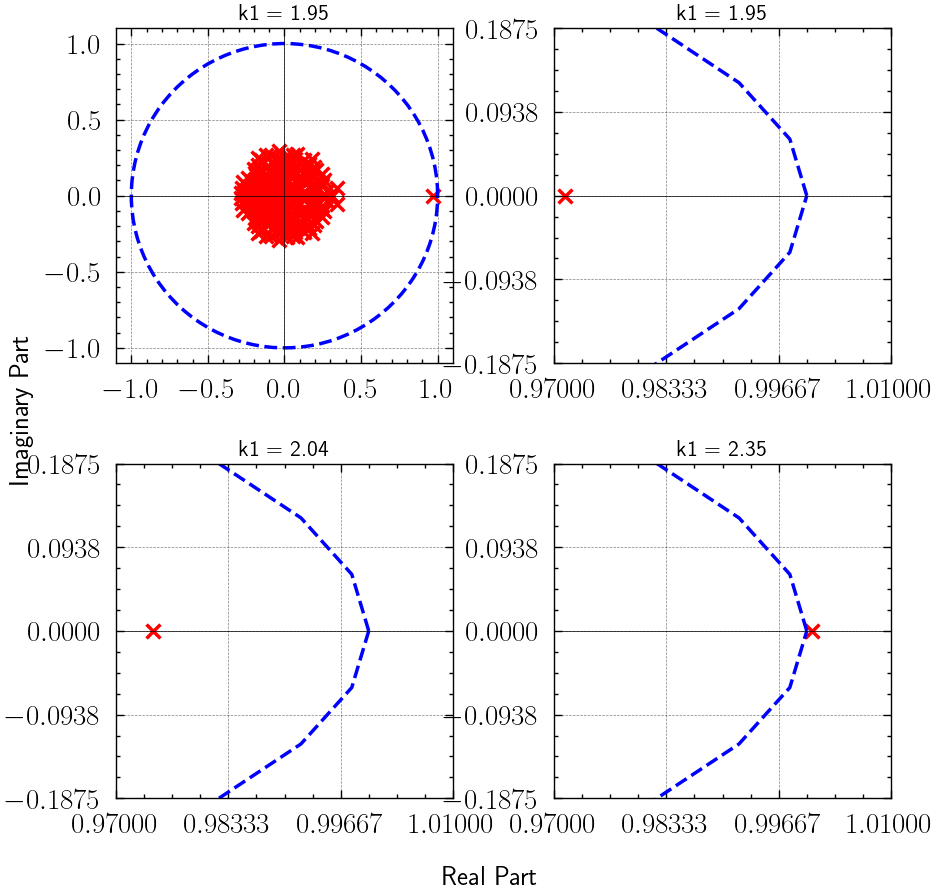

In [55]:
x_lim = [0.97, 1.01, 4]
y_lim = [-0.1875,0.1875, 5]

analysis_model.Plot_eig_values(eig_array,epsilon_list,x_lim,y_lim)

In [ ]:
k_1_values = np.linspace(0.3,4,100)
k2 = 0
x_1_values = []

steps = 20000

fixed_point = []
for k1 in k_1_values:
    k_data = odeint(dxdt, y0=0.09, t=t,args=(k1,k2), tfirst=True)
    x_1_values.append(k_data[990])
    
    initial_condition = 0.9
    prediction = np.zeros((steps, 1))
    r_state = np.ones(dim_reservoir) * initial_condition
    prediction[0] = np.dot(W_out, r_state)
    
    for i in range (1, steps):
        r_state = ((1- alpha)* r_state) + alpha* np.tanh(np.matmul(Lambda, r_state) + k_b * W_b * (k1 - eb))
        prediction[i] = np.transpose(np.dot(W_out, r_state))
    fixed_point.append(prediction.T[:,19990])

plt.scatter(k_1_values,fixed_point,marker='.',label="PARC values")
plt.scatter(k_1_values,x_1_values,marker='.',label="Logistic map values")
plt.xlabel("k1 values")
plt.ylabel("r values")
plt.show()